## Setup

(Lembrar de alocar GPU: Edit>Notebook settings)

Depois de usar muito a GPU, pode acontecer:

"You cannot currently connect to a GPU due to usage limits in Colab. Learn more


To get more access to GPUs, consider purchasing Colab compute units with Pay As You Go."

In [ ]:
#@markdown #**Verificar tipo de GPU**

#@markdown ---




#@markdown V100 = Excelente! (disponível apenas no Colab Pro)

#@markdown P100 = Muito boa.

#@markdown T4 = OK.

#@markdown K80 = Melhor reiniciar.

#@markdown P4 = Impossível! 

#@markdown ---

print("GPU:")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('not found') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\nRAM:")
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

GPU:
Sat May  6 10:38:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [ ]:
#!pip install setuptools==66
#!pip install d2l==1.0.0-beta0

!pip install keras_cv

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_cv
from sklearn.model_selection import train_test_split
from PIL import Image

seeder = 123
#from d2l import tensorflow as d2l

You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [ ]:
print("Versão TF: ", tf.__version__)
print("Modo eager: ", tf.executing_eagerly())
print("TF Functions running eargerly: ", tf.config.functions_run_eagerly())
print("Versão do Hub: ", hub.__version__)
print("Versão do keras_cv:", keras_cv.__version__)
print("GPU", "disponível" if tf.config.experimental.list_physical_devices("GPU") else "NÃO DISPONÍVEL")

Versão TF:  2.12.0
Modo eager:  True
TF Functions running eargerly:  False
Versão do Hub:  0.13.0
Versão do keras_cv: 0.4.2
GPU disponível


# Dados coletados

Os dados foram coletados usando scrapping de imagens do google e consistem de imagens de 3 personagens diferentes de um jogo: Aurelion Sol, Kindred e Teemo. Após o fine-tuning, o modelo irá dizer qual desses 3 personagens está na imagem.

## Download do dataset privado que criei no kaggle

In [ ]:
#(https://www.kaggle.com/general/74235)

# 1. Instalar utilitário de linha de comando
!pip install -q kaggle

# 2. Upar no colab a chave da api da conta do kaggle (kaggle.json) e colocar em ~/.kaggle/kaggle.json
!mkdir ~/.kaggle/
!mv kaggle.json ~/.kaggle/kaggle.json

# 3. Permissão de leitura
!chmod 600 ~/.kaggle/kaggle.json

# 4. Baixar o dataset pelo link da api do dataset (pegar na página do dataset) 
!kaggle datasets download -d alundra/league-of-legends-champions-images

# 5. Descompactar
!mkdir dataset
!unzip league-of-legends-champions-images.zip -d league-dataset

## Construção do dataset tensorflow com Augmentation

In [ ]:
IMAGE_SIZE = (512,512)
BATCH_SIZE = 16
data_dir = "/content/league-dataset" # Diretório das imagens

# Construir dataset a partir do diretório (Labels serão os nomes dos subdiretórios)
# https://www.tensorflow.org/hub/tutorials/tf2_image_retraining
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
            data_dir,
            validation_split=.20,
            subset=subset, # "training" or "validation"
            label_mode="categorical",
            # Seed needs to provided when using validation_split and shuffle = True.
            # A fixed seed is used so that the validation set is stable across runs.
            seed=123,
            image_size=IMAGE_SIZE,
            batch_size=1
        )

train_ds = build_dataset("training")
class_names = np.array(tuple(train_ds.class_names))
print("Classes:", class_names)

train_size = train_ds.cardinality().numpy()
print("Train size: ", train_size)

train_ds = train_ds.unbatch().batch(BATCH_SIZE) # Fazer batch das imagens
train_ds = train_ds.repeat() # Repetir?

normalization_layer = tf.keras.layers.Rescaling(1. / 255) # Normalizar as imagens para valores de 0 a 1

preprocessing_model = tf.keras.Sequential([normalization_layer]) # Modelo para pré-processamento das imagens 

# Fazer data augmentation nas imagens
do_data_augmentation = True
if do_data_augmentation:
    #preprocessing_model.add(tf.keras.layers.RandomBrightness(factor=0.2, value_range=(0.0, 1.0)))
    preprocessing_model.add(tf.keras.layers.RandomRotation(40))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    
    # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
    # image sizes are fixed when reading, and then a random zoom is applied.
    # If all training inputs are larger than image_size, one could also use
    # RandomCrop with a batch size of 1 and rebatch later.
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# Fazer pré-processamento no dataset
train_ds = train_ds.map(
    lambda images, labels: (preprocessing_model(images), labels)
)
#train_ds = train_ds.prefetch(BATCH_SIZE) # <<<

# Mesma coisa com o dataset de validação, mas sem o data augmentation.
val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(
    lambda images, labels: (normalization_layer(images), labels)
)
#val_ds = val_ds.repeat()
#val_ds = val_ds.prefetch(BATCH_SIZE) # <<<

Found 807 files belonging to 3 classes.
Using 646 files for training.
Classes: ['aurelion sol' 'kindred' 'teemo']
Train size:  646


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 807 files belonging to 3 classes.
Using 161 files for validation.


### Visualizar algumas imagens do dataset
(.take() remove as imagens do dataset, então depois de visualizar deve-se executar a célula acima novamente)

In [ ]:
plt.figure(figsize=(30,12))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,3) 

i=0
for img,label in train_ds.take(3):
  #print(img.shape) # (batch?, altura, largura, canaisRGB)
  #print(label)
  axarr[0][i].imshow(img[0])
  axarr[1][i].imshow(img[1])
  axarr[2][i].imshow(img[2])
  axarr[3][i].imshow(img[3])
  i+=1

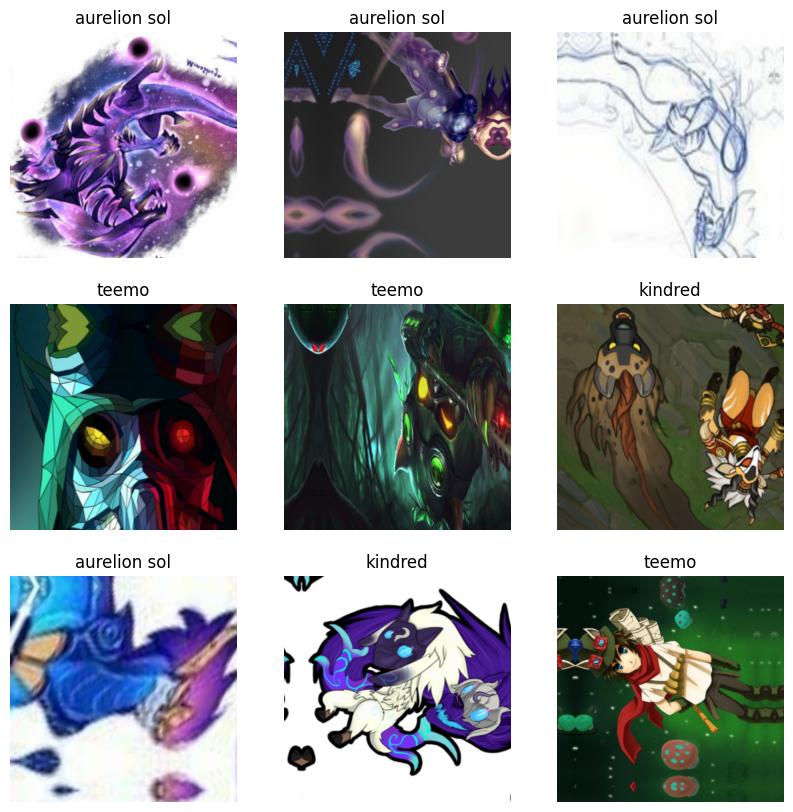

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[tf.where(labels[i])[0][0]])
    plt.axis("off")


# Transferencia de aprendizado
https://www.tensorflow.org/tutorials/images/transfer_learning

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

## MobileNetV2
MobileNetV2 is a general architecture and can be used for multiple use cases. Depending on the use case, it can use different input layer size and different width factors. This allows different width models to reduce the number of multiply-adds and thereby reduce inference cost on mobile devices.

MobileNetV2 is very similar to the original MobileNet, except that it uses inverted residual blocks with bottlenecking features. It has a drastically lower parameter count than the original MobileNet. MobileNets support any input size greater than 32 x 32, with larger image sizes offering better performance.

The number of parameters and number of multiply-adds can be modified by using the alpha parameter, which increases/decreases the number of filters in each layer. By altering the image size and alpha parameter, all 22 models from the paper can be built, with ImageNet weights provided.

In [ ]:
IMG_SIZE = (512, 512)
IMG_SHAPE = IMG_SIZE + (3,)
mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=IMG_SHAPE,
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    pooling="max"
)

#modelo.summary()
# Total params: 2,257,984
# Trainable params: 2,223,872
# Non-trainable params: 34,112

In [ ]:
tf.keras.utils.plot_model(model=mobilenet, show_shapes=True, dpi=76)

In [ ]:
mobilenet.__class__

keras.engine.functional.Functional

### Fine-tuning dos novos layers
Treinar o layer de classificação primeiro, com o layer do mobilenet congelado

In [ ]:
print(mobilenet.trainable)
mobilenet.trainable = False
print(mobilenet.trainable)
mobilenet.summary()
# >> Total params: 2,257,984
# >> Trainable params: 0
# >> Non-trainable params: 2,257,984

#### Construindo o modelo a partir da Functional API (apenas para aprendizado)

( https://www.tensorflow.org/guide/keras/functional#introduction )

In [ ]:
# modelo.add(
#     tf.keras.layers.Dropout(rate=0.2), # Adicionar um layer de droupout para evitar overfitting
#     tf.keras.layers.Dense( # Layer de classificação
#         3, # Quantidade de classes (depende do que irá se classificar)
#         kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seeder),
#         kernel_regularizer=tf.keras.regularizers.l2(0.0001)
#     )
# )

layer_input = tf.keras.layers.Input(shape=IMG_SHAPE)
x = mobilenet(layer_input) # conectar os layers

dropout = tf.keras.layers.Dropout(rate=0.2)
x = dropout(x)


head = tf.keras.layers.Dense( # Layer de output
    3, # Quantidade de classes
    kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seeder),
    kernel_regularizer=tf.keras.regularizers.l2(0.0001)
)
modelo_novo_functional = head(x)
# modelo_novo_functional.summary() --> 'KerasTensor' object has no attribute 'summary'

modelo_novo_model = tf.keras.Model(
      inputs=layer_input,
      outputs=modelo_novo_functional
)

In [ ]:
modelo_novo_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


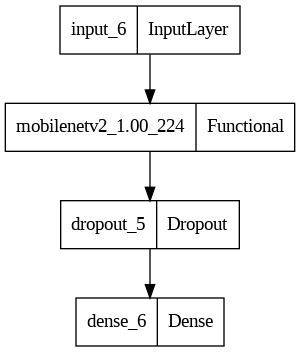

In [ ]:
tf.keras.utils.plot_model(modelo_novo_model, "mobilenet new head.png")

#### Construindo o modelo pelo keras.Sequential

In [ ]:
modelo_novo = tf.keras.Sequential([
    mobilenet,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(
        3,
        kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seeder),
        kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )
])
#modelo_novo.build((None,)+IMAGE_SIZE+(3,))
modelo_novo.summary()
# >> Total params: 2,261,827
# >> Trainable params: 3,843
# >> Non-trainable params: 2,257,984

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


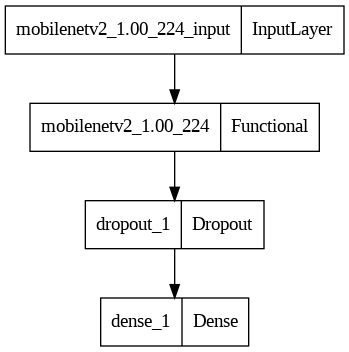

In [ ]:
tf.keras.utils.plot_model(modelo_novo, "mobilenet fine-tune.png")

In [ ]:
lr_classification_head = 0.001
modelo_novo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_classification_head), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
print(len(modelo_novo.trainable_variables))

2


In [ ]:
loss0, accuracy0 = modelo_novo.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 4s 353ms/step - loss: 1.1819 - accuracy: 0.3727
initial loss: 1.18
initial accuracy: 0.37


In [ ]:
# As you are training a much larger model and want to readapt the pretrained weights, it is
# important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
total_epochs = 20

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history = modelo_novo.fit(
    train_ds,
    epochs=total_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps
)

Epoch 1/20
40/40 [==============================] - 89s 2s/step - loss: 1.6994 - accuracy: 0.4875 - val_loss: 1.6065 - val_accuracy: 0.3938
Epoch 2/20
40/40 [==============================] - 89s 2s/step - loss: 1.0717 - accuracy: 0.6079 - val_loss: 0.6313 - val_accuracy: 0.7312
Epoch 3/20
40/40 [==============================] - 85s 2s/step - loss: 0.7607 - accuracy: 0.6921 - val_loss: 0.4675 - val_accuracy: 0.8188
Epoch 4/20
40/40 [==============================] - 84s 2s/step - loss: 0.7786 - accuracy: 0.6810 - val_loss: 0.3974 - val_accuracy: 0.8062
Epoch 5/20
40/40 [==============================] - 81s 2s/step - loss: 0.6760 - accuracy: 0.7381 - val_loss: 0.3531 - val_accuracy: 0.8313
Epoch 6/20
40/40 [==============================] - 86s 2s/step - loss: 0.6231 - accuracy: 0.7508 - val_loss: 0.4149 - val_accuracy: 0.8375
Epoch 7/20
40/40 [==============================] - 84s 2s/step - loss: 0.5159 - accuracy: 0.7905 - val_loss: 0.5536 - val_accuracy: 0.7812
Epoch 8/20
40/40 [==

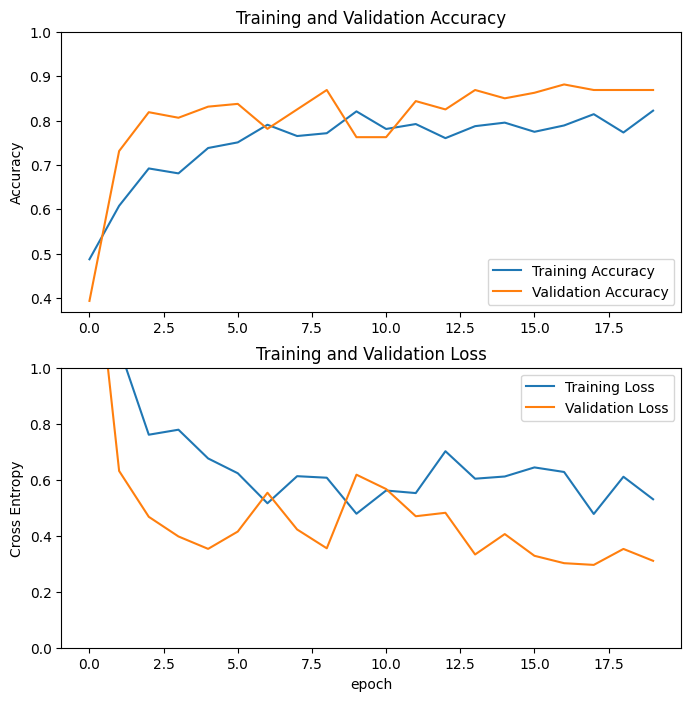

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Fine-tuning com o mobilenet não congelado

"Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.
"

(https://www.tensorflow.org/tutorials/images/transfer_learning#fine_tuning)

In [ ]:
modelo_novo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
mobilenet.trainable = True
modelo_novo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:

#Fine-tune from this layer onwards
fine_tune_at = 100 #(mobilenet tem 155 layers)

#Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet.layers[:fine_tune_at]:
    layer.trainable = False

for layer in mobilenet.layers:
    if "bn" in layer.name or "BN" in layer.name:
        layer.trainable = False

modelo_novo.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 1,843,459
Non-trainable params: 418,368
_________________________________________________________________


#### Treinamento

In [ ]:
# Algumas informações dos Layers do modelo
print(f"Treinável: {modelo_novo.trainable}")
print("Number of layers in the base model: ", len(modelo_novo.layers))
print(len(modelo_novo.trainable_variables))

Treinável: True
Number of layers in the base model:  3
20


In [ ]:
lr_modelo_novo = 0.0001 # Usar um learning rate menor do que quando só treinou os novos layers
modelo_novo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_modelo_novo), 
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
loss0, accuracy0 = modelo_novo.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

11/11 [==============================] - 5s 395ms/step - loss: 0.3103 - accuracy: 0.8696
initial loss: 0.31
initial accuracy: 0.87


In [ ]:
# As you are training a much larger model and want to readapt the pretrained weights, it is
# important to use a lower learning rate at this stage. Otherwise, your model could overfit very quickly.
finetune_epochs =  20

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
history_ft = modelo_novo.fit(
    train_ds,
    epochs=finetune_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps
)


Epoch 1/20
40/40 [==============================] - 87s 2s/step - loss: 0.8693 - accuracy: 0.6875 - val_loss: 0.4834 - val_accuracy: 0.7688
Epoch 2/20
40/40 [==============================] - 89s 2s/step - loss: 0.5041 - accuracy: 0.8016 - val_loss: 0.6651 - val_accuracy: 0.7500
Epoch 3/20
40/40 [==============================] - 82s 2s/step - loss: 0.4604 - accuracy: 0.8286 - val_loss: 0.2471 - val_accuracy: 0.9125
Epoch 4/20
40/40 [==============================] - 86s 2s/step - loss: 0.3306 - accuracy: 0.8857 - val_loss: 0.2472 - val_accuracy: 0.9062
Epoch 5/20
40/40 [==============================] - 80s 2s/step - loss: 0.2959 - accuracy: 0.8873 - val_loss: 0.5260 - val_accuracy: 0.8313
Epoch 6/20
40/40 [==============================] - 81s 2s/step - loss: 0.2887 - accuracy: 0.8889 - val_loss: 0.2733 - val_accuracy: 0.9062
Epoch 7/20
40/40 [==============================] - 83s 2s/step - loss: 0.3795 - accuracy: 0.8429 - val_loss: 0.7362 - val_accuracy: 0.7375
Epoch 8/20
40/40 [==

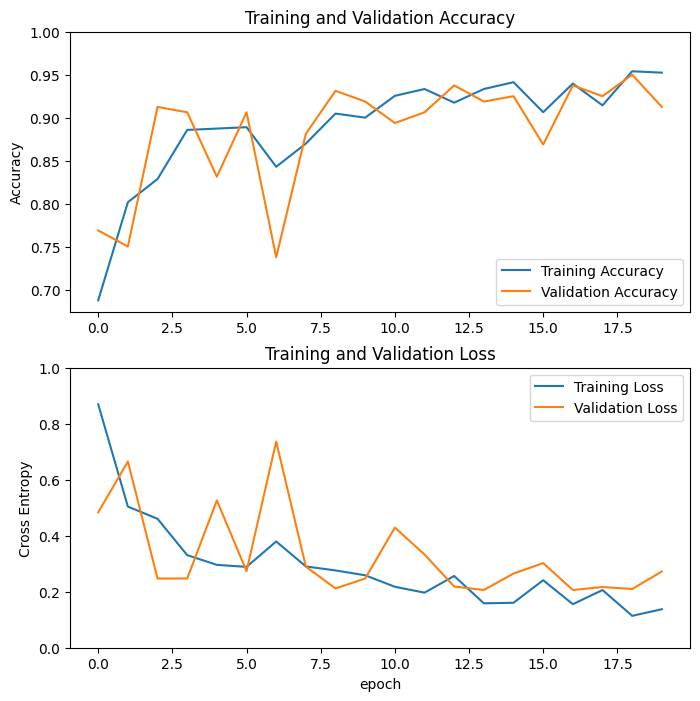

In [ ]:
acc = history_ft.history['accuracy']
val_acc = history_ft.history['val_accuracy']

loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


### Predição
( https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub#an_imagenet_classifier )

(512, 512, 3)
float32
1.0


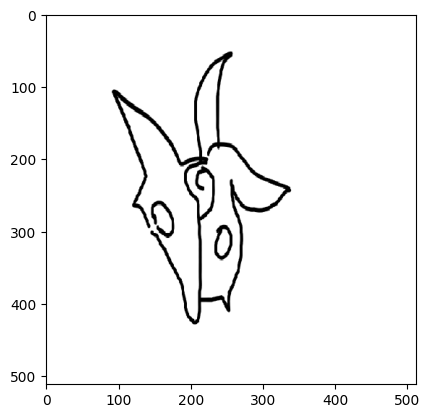

In [ ]:
# img_kindred = tf.keras.utils.get_file('kindred.jpg','https://i.pinimg.com/originals/5e/2e/95/5e2e95e0099f516abe38b8c8e33f715f.jpg')
# img_kindred = Image.open(img_kindred).resize((512,512))
# img_kindred = np.array(img_kindred)/255.0

img_kindred = tf.keras.preprocessing.image.load_img("/content/kindred_drawing.png", target_size=(512,512))
img_kindred = tf.keras.preprocessing.image.img_to_array(img_kindred)
img_kindred = img_kindred/255.0

print(img_kindred.shape)
print(img_kindred.dtype)
print(img_kindred.max())
plt.imshow(img_kindred)

(512, 512, 3)


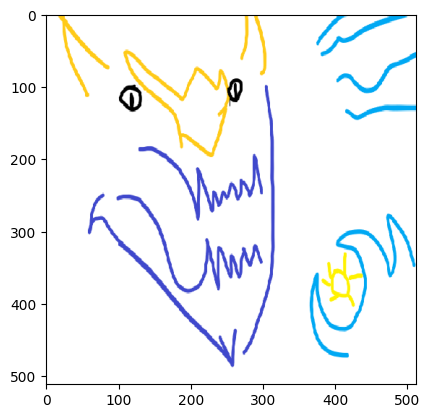

In [ ]:
# img_asol = tf.keras.utils.get_file('aurelion.jpg','https://i.redd.it/lb98gi1ao8s31.jpg')
# img_asol = Image.open(img_asol).resize((224,224))
# img_asol = np.array(img_asol)/255.0

img_asol = tf.keras.preprocessing.image.load_img("/content/asol3.jpg", target_size=(512,512))
img_asol = tf.keras.preprocessing.image.img_to_array(img_asol)
img_asol = img_asol/255.0
#img_asol = tf.expand_dims(img_asol, 0) # Expandir a dimensão antes do predict por conta da dimensão de batch
print(img_asol.shape)
plt.imshow(img_asol)

(512, 512, 3)


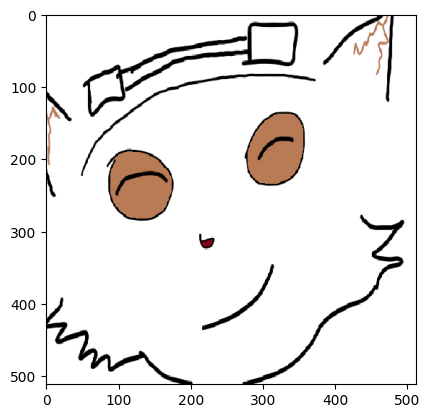

In [ ]:
# img_teemo = tf.keras.utils.get_file('teemo1.jpg','https://pbs.twimg.com/media/EXJv8u9XkAMUu3c.jpg')
# img_teemo = Image.open(img_teemo).resize((224,224))
# img_teemo = np.array(img_teemo)/255.0
# # Converter de (224,224) para (224,224,3) caso necessário
# #img_teemo = img_teemo[..., np.newaxis]
# #img_teemo = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img_teemo))

img_teemo = tf.keras.preprocessing.image.load_img("/content/teemo_drawing.png", target_size=(512,512))
img_teemo = tf.keras.preprocessing.image.img_to_array(img_teemo)
img_teemo = img_teemo/255.0

print(img_teemo.shape)
plt.imshow(img_teemo)

In [ ]:
result = modelo_novo.predict(img_kindred[np.newaxis, ...]) #Add a batch dimension (with np.newaxis) and pass the image to the model:
#print(result.shape) # (1, 3) --> 1 prediction com 3 classes

result = result.squeeze() # squeeze() pois a prediction foi com apenas 1 exemplo

probabilidades = (tf.nn.softmax(result) * 100).numpy()

print("Probabilidades associadas às classes:")
print("[aurelion, kindred, teemo]")
print(probabilidades)

print("Personagem:", class_names[result.argmax()], "- Confiança:", probabilidades[result.argmax()])

1/1 [==============================] - 0s 104ms/step
Probabilidades associadas às classes: (aurelion, kindred, teemo)
[60.611248 27.148804 12.239948]
Personagem: aurelion sol - Confiança: 60.611248


In [ ]:
result = modelo_novo.predict(tf.expand_dims(img_asol, 0))
result = result.squeeze()

probabilidades = (tf.nn.softmax(result) * 100).numpy()

print("Probabilidades associadas às classes:")
print("[aurelion, kindred, teemo]")
print(probabilidades)

print("Personagem:", class_names[result.argmax()], "- Confiança:", probabilidades[result.argmax()])

1/1 [==============================] - 0s 136ms/step
Probabilidades associadas às classes: (aurelion, kindred, teemo)
[98.47927    1.1918986  0.3288293]
Personagem: aurelion sol - Confiança: 98.47927


In [ ]:
result = modelo_novo.predict(img_teemo[np.newaxis, ...])
result = result.squeeze()

probabilidades = (tf.nn.softmax(result) * 100).numpy()

print("Probabilidades associadas às classes:")
print("[aurelion, kindred, teemo]")
print(probabilidades)

print("Personagem:", class_names[result.argmax()], "- Confiança:", probabilidades[result.argmax()])

1/1 [==============================] - 0s 100ms/step
Probabilidades associadas às classes:
[aurelion, kindred, teemo]
[18.02791     0.89759344 81.0745    ]
Personagem: teemo - Confiança: 81.0745


#### Predict com um dataset

In [ ]:
test = val_ds.take(1)

In [ ]:
predicoes = modelo_novo.predict(test)
for p in predicoes:
    print("Personagem:", class_names[p.argmax()])

1/1 [==============================] - 1s 641ms/step
Personagem: teemo
Personagem: teemo
Personagem: kindred
Personagem: kindred
Personagem: aurelion sol
Personagem: kindred
Personagem: kindred
Personagem: aurelion sol
Personagem: aurelion sol
Personagem: teemo
Personagem: kindred
Personagem: kindred
Personagem: teemo
Personagem: teemo
Personagem: aurelion sol
Personagem: kindred


In [ ]:
# for img,label in val_ds.take(3)...
# https://www.tensorflow.org/tutorials/images/transfer_learning#evaluation_and_prediction
i=-1
for img_batch,label_batch in test:
  for img,label in zip(img_batch, label_batch):
    i+=1
    plt.figure(figsize=(3,3))
    plt.imshow(img) # considerar o batch no val_ds.take...
    #plt.title(label)
    print("Personagem:", class_names[predicoes[i].argmax()])
    plt.show()

#### Visualizar predição (não está funcionando)
https://www.tensorflow.org/tutorials/keras/classification#make_predictions

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  #true_label= true_label[i]
  #img=img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  #true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


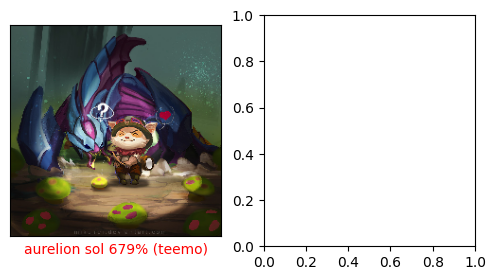

In [ ]:
i = 2
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, result, "teemo", img_teemo)
plt.subplot(1,2,2)
#plot_value_array(i, result,  "teemo")
plt.show()

### Salvar os pesos do modelo
To save weights manually, use tf.keras.Model.save_weights. By default, tf.keras—and the Model.save_weights method in particular—uses the TensorFlow Checkpoint format with a .ckpt extension. To save in the HDF5 format with a .h5 extension, refer to the Save and load models guide.
https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Salvar os pesos
modelo_novo.save_weights('/content/pesos_salvos/modelo_novo_weights')

In [ ]:
def create_model():
  model = tf.keras.Sequential([
      mobilenet,
      tf.keras.layers.Dropout(rate=0.2),
      tf.keras.layers.Dense(
          3,
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=seeder),
          kernel_regularizer=tf.keras.regularizers.l2(0.0001)
      )
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_classification_head), 
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
      metrics=['accuracy']
  )

  return model

# Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('/content/pesos_salvos/modelo_novo_weights')

# Evaluate the model
loss, acc = model.evaluate(val_ds)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

11/11 [==============================] - 5s 327ms/step - loss: 0.2878 - accuracy: 0.9255
Restored model, accuracy: 92.55%


### Salvar o modelo inteiro
https://www.tensorflow.org/tutorials/keras/save_and_load#savedmodel_format

Call tf.keras.Model.save to save a model's architecture, weights, and training configuration in a single file/folder. This allows you to export a model so it can be used without access to the original Python code*. Since the optimizer-state is recovered, you can resume training from exactly where you left off.

An entire model can be saved in two different file formats (SavedModel and HDF5). The TensorFlow SavedModel format is the default file format in TF2.x. However, models can be saved in HDF5 format. More details on saving entire models in the two file formats is described below.

Saving a fully-functional model is very useful—you can load them in TensorFlow.js (Saved Model, HDF5) and then train and run them in web browsers, or convert them to run on mobile devices using TensorFlow Lite (Saved Model, HDF5)

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p modelos_salvos
modelo_novo.save('modelos_salvos/leaguenet')

In [ ]:
# Contains an assets folder, saved_model.pb, and variables folder.
!ls modelos_salvos/leaguenet

assets	fingerprint.pb	keras_metadata.pb  saved_model.pb  variables


In [ ]:
teste_load_model = tf.keras.models.load_model('modelos_salvos/leaguenet')

# Check its architecture
teste_load_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 1,843,459
Non-trainable params: 418,368
_________________________________________________________________


In [ ]:
# Evaluate the restored model
loss, acc = teste_load_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))
print(teste_load_model.predict(val_ds).shape)

11/11 - 5s - loss: 0.2707 - accuracy: 0.9130 - 5s/epoch - 454ms/step
Restored model, accuracy: 91.30%
11/11 [==============================] - 5s 403ms/step
(161, 3)


In [ ]:
!zip -r /content/leaguenet.zip /content/modelos_salvos/leaguenet

from google.colab import files
files.download("/content/leaguenet.zip")

  adding: content/modelos_salvos/leaguenet/ (stored 0%)
  adding: content/modelos_salvos/leaguenet/assets/ (stored 0%)
  adding: content/modelos_salvos/leaguenet/saved_model.pb (deflated 91%)
  adding: content/modelos_salvos/leaguenet/variables/ (stored 0%)
  adding: content/modelos_salvos/leaguenet/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/modelos_salvos/leaguenet/variables/variables.index (deflated 76%)
  adding: content/modelos_salvos/leaguenet/keras_metadata.pb (deflated 96%)
  adding: content/modelos_salvos/leaguenet/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Converter para modelo tensorflow.js
https://www.tensorflow.org/js/tutorials/conversion/import_saved_model

~~ https://www.tensorflow.org/js/tutorials/conversion/import_keras ~~

In [ ]:
!git clone https://github.com/Jp9910/Projeto-AM
!mv /content/Projeto-AM/model /content/leaguenet_v1.zip
!unzip /content/leaguenet_v1.zip -d leaguenet
!rm -rf /content/Projeto-AM

Cloning into 'Projeto-AM'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 85 (delta 40), reused 70 (delta 28), pack-reused 0
Unpacking objects: 100% (85/85), 25.97 MiB | 8.25 MiB/s, done.


In [ ]:
!unzip /content/leaguenet_v1.zip -d leaguenet

Archive:  /content/leaguenet_v1.zip
   creating: leaguenet/content/modelos_salvos/leaguenet/
   creating: leaguenet/content/modelos_salvos/leaguenet/assets/
  inflating: leaguenet/content/modelos_salvos/leaguenet/saved_model.pb  
   creating: leaguenet/content/modelos_salvos/leaguenet/variables/
  inflating: leaguenet/content/modelos_salvos/leaguenet/variables/variables.data-00000-of-00001  
  inflating: leaguenet/content/modelos_salvos/leaguenet/variables/variables.index  
  inflating: leaguenet/content/modelos_salvos/leaguenet/keras_metadata.pb  
 extracting: leaguenet/content/modelos_salvos/leaguenet/fingerprint.pb  


In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --help

In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --saved_model_tags=serve \
    /content/leaguenet/content/modelos_salvos/leaguenet \
    /content/tfjs_model


2023-05-07 06:12:04.877000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 06:12:05.948725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-07 06:12:14.045329: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-05-07 06:12:14.045600: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


In [ ]:
!zip -r /content/leaguenetJS.zip /content/tfjs_model
from google.colab import files
files.download("/content/leaguenetJS_v1.zip")

  adding: content/tfjs_model/ (stored 0%)
  adding: content/tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: content/tfjs_model/model.json (deflated 95%)
  adding: content/tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: content/tfjs_model/group1-shard1of3.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Alguns testes com outros modelos que pensei em usar para o projeto

## Stable diffusion do KerasCV 
(GPUs no colab não tiveram memória suficiente para o fine-tuning com a base de dados)

In [ ]:
tf.keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(img_height=512,img_width=512,jit_compile=True)


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [ ]:
# Warm up model to run graph tracing before benchmarking.
model.text_to_image("warming up the model", batch_size=2)

In [ ]:
images = model.text_to_image(
    "skeleton pirate, high quality, highly detailed, sharp focus, concept art, character concepts, digital painting",
    batch_size=3,
)

50/50 [==============================] - 35s 702ms/step


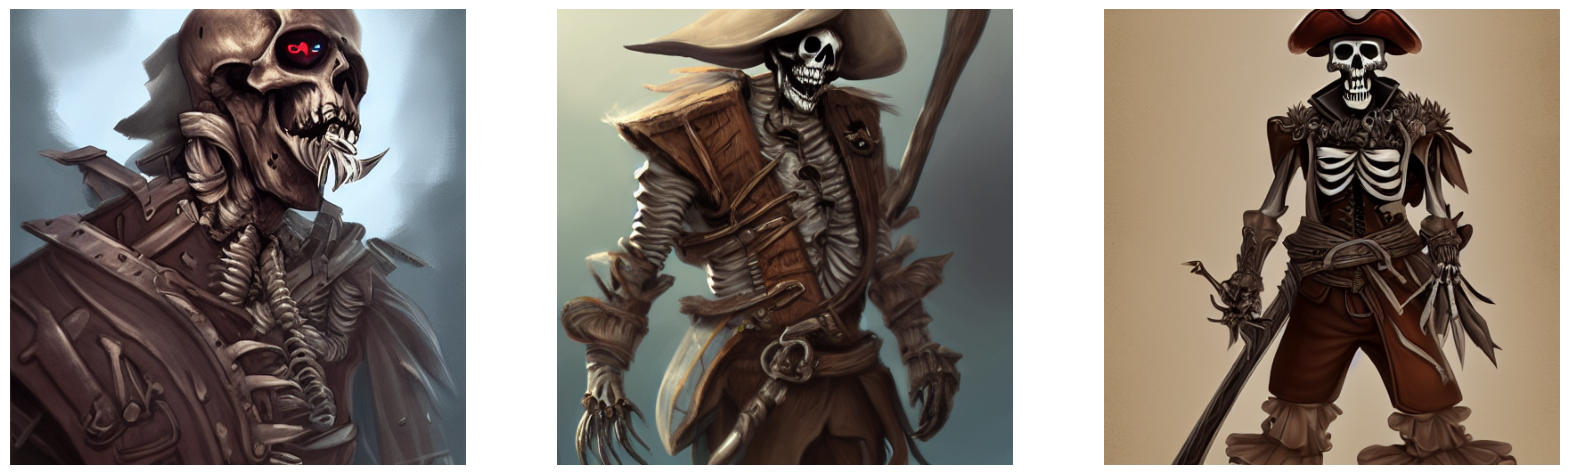

In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

In [ ]:
Image.fromarray(images[0]).save("output2.png")
Image.fromarray(images[1]).save("output3.png")
Image.fromarray(images[2]).save("output4.png")

### Fine-tuning
( https://keras.io/examples/generative/finetune_stable_diffusion/ )

In [ ]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder

#### Data loading
We use the dataset
[Pokémon BLIP captions](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions).
However, we'll use a slightly different version which was derived from the original
dataset to fit better with `tf.data`. Refer to
[the documentation](https://huggingface.co/datasets/sayakpaul/pokemon-blip-original-version)
for more details.

In [ ]:
data_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/datasets/sayakpaul/pokemon-blip-original-version/resolve/main/pokemon_dataset.tar.gz",
    untar=True,
)

data_frame = pd.read_csv(os.path.join(data_path, "data.csv"))

data_frame["image_path"] = data_frame["image_path"].apply(
    lambda x: os.path.join(data_path, x)
)
data_frame.head()

347504640/347504640 [==============================] - 7s 0us/step


,image_path,caption
0,/root/.keras/datasets/pokemon_dataset/image_0.png,a drawing of a green pokemon with red eyes
1,/root/.keras/datasets/pokemon_dataset/image_1.png,a green and yellow toy with a red nose
2,/root/.keras/datasets/pokemon_dataset/image_2.png,a red and white ball with an angry look on its...
3,/root/.keras/datasets/pokemon_dataset/image_3.png,a cartoon ball with a smile on it's face
4,/root/.keras/datasets/pokemon_dataset/image_4.png,a bunch of balls with faces drawn on them


Since we have only 833 `{image, caption}` pairs, we can precompute the text embeddings from
the captions. Moreover, the text encoder will be kept frozen during the course of
fine-tuning, so we can save some compute by doing this.

Before we use the text encoder, we need to tokenize the captions.

In [ ]:
# The padding token and maximum prompt length are specific to the text encoder.
# If you're using a different text encoder be sure to change them accordingly.
PADDING_TOKEN = 49407
MAX_PROMPT_LENGTH = 77

# Load the tokenizer.
tokenizer = SimpleTokenizer()

#  Method to tokenize and pad the tokens.
def process_text(caption):
    tokens = tokenizer.encode(caption)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    return np.array(tokens)


# Collate the tokenized captions into an array.
tokenized_texts = np.empty((len(data_frame), MAX_PROMPT_LENGTH))

all_captions = list(data_frame["caption"].values)
for i, caption in enumerate(all_captions):
    tokenized_texts[i] = process_text(caption)

1356917/1356917 [==============================] - 0s 0us/step


#### Prepare a `tf.data.Dataset`

In this section, we'll prepare a `tf.data.Dataset` object from the input image file paths
and their corresponding caption tokens. The section will include the following:

* Pre-computation of the text embeddings from the tokenized captions.
* Loading and augmentation of the input images.
* Shuffling and batching of the dataset.

In [ ]:
RESOLUTION = 256
AUTO = tf.data.AUTOTUNE
POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)

augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.CenterCrop(RESOLUTION, RESOLUTION),
        keras_cv.layers.RandomFlip(),
        tf.keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ]
)
text_encoder = TextEncoder(MAX_PROMPT_LENGTH)


def process_image(image_path, tokenized_text):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, 3)
    image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
    return image, tokenized_text


def apply_augmentation(image_batch, token_batch):
    return augmenter(image_batch), token_batch


def run_text_encoder(image_batch, token_batch):
    return (
        image_batch,
        token_batch,
        text_encoder([token_batch, POS_IDS], training=False),
    )


def prepare_dict(image_batch, token_batch, encoded_text_batch):
    return {
        "images": image_batch,
        "tokens": token_batch,
        "encoded_text": encoded_text_batch,
    }


def prepare_dataset(image_paths, tokenized_texts, batch_size=1):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, tokenized_texts))
    dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.map(process_image, num_parallel_calls=AUTO).batch(batch_size)
    dataset = dataset.map(apply_augmentation, num_parallel_calls=AUTO)
    dataset = dataset.map(run_text_encoder, num_parallel_calls=AUTO)
    dataset = dataset.map(prepare_dict, num_parallel_calls=AUTO)
    return dataset.prefetch(AUTO)


492466864/492466864 [==============================] - 6s 0us/step


The baseline Stable Diffusion model was trained using images with 512x512 resolution. It's
unlikely for a model that's trained using higher-resolution images to transfer well to
lower-resolution images. However, the current model will lead to OOM if we keep the
resolution to 512x512 (without enabling mixed-precision). Therefore, in the interest of
interactive demonstrations, we kept the input resolution to 256x256.

In [ ]:
# Prepare the dataset.
training_dataset = prepare_dataset(
    np.array(data_frame["image_path"]), tokenized_texts, batch_size=4
)

# Take a sample batch and investigate.
sample_batch = next(iter(training_dataset))

for k in sample_batch:
    print(k, sample_batch[k].shape)

images (4, 256, 256, 3)
tokens (4, 77)
encoded_text (4, 77, 768)


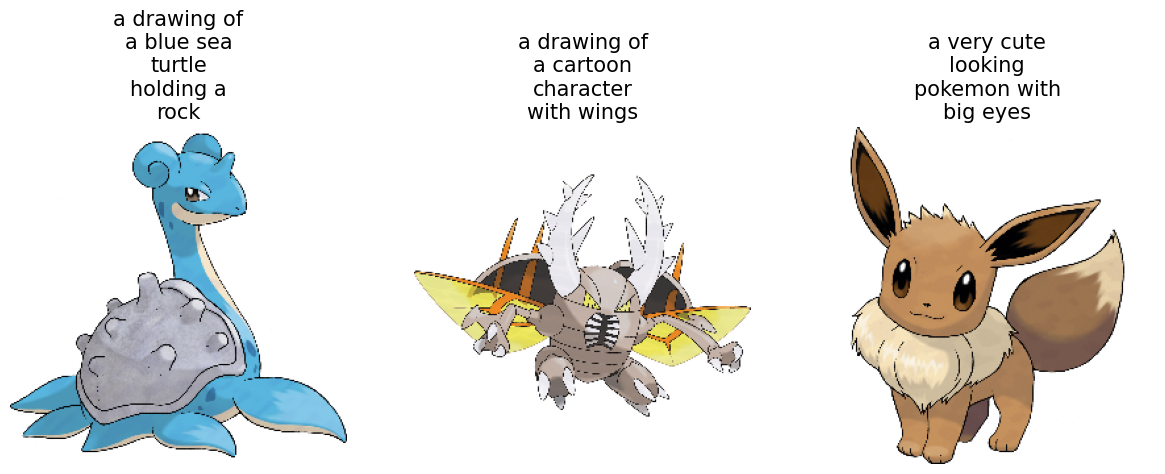

In [ ]:
from textwrap import wrap
plt.figure(figsize=(20, 10))

for i in range(3):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow((sample_batch["images"][i] + 1) / 2)

    text = tokenizer.decode(sample_batch["tokens"][i].numpy().squeeze())
    text = text.replace("<|startoftext|>", "")
    text = text.replace("<|endoftext|>", "")
    text = "\n".join(wrap(text, 12))
    plt.title(text, fontsize=15)

    plt.axis("off")

#### A trainer class for the fine-tuning loop

In [ ]:

class Trainer(tf.keras.Model):
    # Reference:
    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image.py

    def __init__(
        self,
        diffusion_model,
        vae,
        noise_scheduler,
        use_mixed_precision=False,
        max_grad_norm=1.0,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.diffusion_model = diffusion_model
        self.vae = vae
        self.noise_scheduler = noise_scheduler
        self.max_grad_norm = max_grad_norm

        self.use_mixed_precision = use_mixed_precision
        self.vae.trainable = False

    def train_step(self, inputs):
        images = inputs["images"]
        encoded_text = inputs["encoded_text"]
        batch_size = tf.shape(images)[0]

        with tf.GradientTape() as tape:
            # Project image into the latent space and sample from it.
            latents = self.sample_from_encoder_outputs(self.vae(images, training=False))
            # Know more about the magic number here:
            # https://keras.io/examples/generative/fine_tune_via_textual_inversion/
            latents = latents * 0.18215

            # Sample noise that we'll add to the latents.
            noise = tf.random.normal(tf.shape(latents))

            # Sample a random timestep for each image.
            timesteps = tnp.random.randint(
                0, self.noise_scheduler.train_timesteps, (batch_size,)
            )

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process).
            noisy_latents = self.noise_scheduler.add_noise(
                tf.cast(latents, noise.dtype), noise, timesteps
            )

            # Get the target for loss depending on the prediction type
            # just the sampled noise for now.
            target = noise  # noise_schedule.predict_epsilon == True

            # Predict the noise residual and compute loss.
            timestep_embedding = tf.map_fn(
                lambda t: self.get_timestep_embedding(t), timesteps, dtype=tf.float32
            )
            timestep_embedding = tf.squeeze(timestep_embedding, 1)
            model_pred = self.diffusion_model(
                [noisy_latents, timestep_embedding, encoded_text], training=True
            )
            loss = self.compiled_loss(target, model_pred)
            if self.use_mixed_precision:
                loss = self.optimizer.get_scaled_loss(loss)

        # Update parameters of the diffusion model.
        trainable_vars = self.diffusion_model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        if self.use_mixed_precision:
            gradients = self.optimizer.get_unscaled_gradients(gradients)
        gradients = [tf.clip_by_norm(g, self.max_grad_norm) for g in gradients]
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {m.name: m.result() for m in self.metrics}

    def get_timestep_embedding(self, timestep, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return embedding

    def sample_from_encoder_outputs(self, outputs):
        mean, logvar = tf.split(outputs, 2, axis=-1)
        logvar = tf.clip_by_value(logvar, -30.0, 20.0)
        std = tf.exp(0.5 * logvar)
        sample = tf.random.normal(tf.shape(mean), dtype=mean.dtype)
        return mean + std * sample

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        # Overriding this method will allow us to use the `ModelCheckpoint`
        # callback directly with this trainer class. In this case, it will
        # only checkpoint the `diffusion_model` since that's what we're training
        # during fine-tuning.
        self.diffusion_model.save_weights(
            filepath=filepath,
            overwrite=overwrite,
            save_format=save_format,
            options=options,
        )


One important implementation detail to note here: Instead of directly taking
the latent vector produced by the image encoder (which is a VAE), we sample from the
mean and log-variance predicted by it. This way, we can achieve better sample
quality and diversity.

It's common to add support for mixed-precision training along with exponential
moving averaging of model weights for fine-tuning these models. However, in the interest
of brevity, we discard those elements. More on this later in the tutorial.

#### Initialize the trainer and compile it

In [ ]:
# Enable mixed-precision training if the underlying GPU has tensor cores.
USE_MP = True
if USE_MP:
    tf.keras.mixed_precision.set_global_policy("mixed_float16")

image_encoder = ImageEncoder(RESOLUTION, RESOLUTION)
diffusion_ft_trainer = Trainer(
    diffusion_model=DiffusionModel(RESOLUTION, RESOLUTION, MAX_PROMPT_LENGTH),
    # Remove the top layer from the encoder, which cuts off the variance and only
    # returns the mean.
    vae=tf.keras.Model(
        image_encoder.input,
        image_encoder.layers[-2].output,
    ),
    noise_scheduler=NoiseScheduler(),
    use_mixed_precision=USE_MP,
)

# These hyperparameters come from this tutorial by Hugging Face:
# https://huggingface.co/docs/diffusers/training/text2image
lr = 1e-5
beta_1, beta_2 = 0.9, 0.999
weight_decay = (1e-2,)
epsilon = 1e-08

optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=lr,
    weight_decay=weight_decay,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
)
diffusion_ft_trainer.compile(optimizer=optimizer, loss="mse")

3439090152/3439090152 [==============================] - 47s 0us/step


In [ ]:
# Fine-tuning
# Tentar https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
import tensorflow.experimental.numpy as tnp

epochs = 3
ckpt_path = "finetuned_stable_diffusion.h5"
# tf.keras.callbacks: utilities called at certain points during model training
# tf.keras.callbacks.ModelCheckpoint: Callback to save the Keras model or model weights at some frequency
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    monitor="loss",
    mode="min",
)
diffusion_ft_trainer.fit(training_dataset, epochs=epochs, callbacks=[ckpt_callback])

Epoch 1/3


Instructions for updating:
Use fn_output_signature instead


ResourceExhaustedError: ignored

In [ ]:
print(1)

## Testes usando um modelo do tfhub
https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb#scrollTo=umB5tswsfTEQ&line=4&uniqifier=1

In [ ]:
model_handle = "https://tfhub.dev/deepmind/biggan-512/2"
IMAGE_SIZE = (512,512)
fine_tune = True #@param {type:"boolean"}

In [ ]:
hub_model_layer = hub.KerasLayer(model_handle, trainable=fine_tune)
hub_model_layer.__class__

tensorflow_hub.keras_layer.KerasLayer

In [ ]:
print("Building model with", model_handle)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)), # IMAGE_SIZE + (3,) para adicionar as 3 camadas de cores RGB
    hub_model_layer,
    tf.keras.layers.Dropout(rate=0.2), # Adicionar um layer de droupout para evitar overfitting
    tf.keras.layers.Dense( # Layer de classificação
        5, # Quantidade de classes (depende do que irá se classificar)
        kernel_regularizer=tf.keras.regularizers.l2(0.0001)
    )
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              207615832 
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 207,622,237
Trainable params: 206,845,213
Non-trainable params: 777,024
_________________________________________________________________


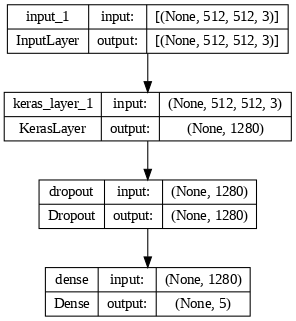

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [ ]:
# tf.keras.Model:
# A model grouping layers into an object with training/inference features.
# modelo = tf.keras.Model(inputs=input, outputs=output)
teste = tf.keras.Model(layer)

In [ ]:
teste.__class__

keras.engine.training.Model

## ResNet

In [ ]:
modelo = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None
)

# Total params: 25,636,712
# Trainable params: 25,583,592
# Non-trainable params: 53,120

102967424/102967424 [==============================] - 1s 0us/step


In [ ]:
modelo.summary()

### Fine-tuning

In [ ]:
modelo.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(modelo.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in modelo.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  177


In [ ]:
len(model.trainable_variables)

NameError: ignored

In [ ]:
base_learning_rate = 0.0001
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy']
)

## Stable-diffusion (torch)

In [ ]:
!pip install --upgrade diffusers[torch]
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.3 MB/s eta 0:00:00


In [ ]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]  
    
image.save("astronaut_rides_horse.png")


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3553 in run_code         │
│                                                                                                  │
│   3550 │   │   │   │   elif async_ :                                                             │
│   3551 │   │   │   │   │   await eval(code_obj, self.user_global_ns, self.user_ns)               │
│   3552 │   │   │   │   else:                                                                     │
│ ❱ 3553 │   │   │   │   │   exec(code_obj, self.user_global_ns, self.user_ns)                     │
│   3554 │   │   │   finally:                                                                      │
│   3555 │   │   │   │   # Reset our crash handler in place                                        │
│   3556 │   │   │   │   sys.excepthook = old_excepthook                                           │
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/diffusers/utils/dummy_torch_and_transformers_objects.py:3 │
│ 02 in from_pretrained                                                                            │
│                                                                                                  │
│   299 │                                                                                          │
│   300 │   @classmethod                                                                           │
│   301 │   def from_pretrained(cls, *args, **kwargs):                                             │
│ ❱ 302 │   │   requires_backends(cls, ["torch", "transformers"])                                  │
│   303                                                                                            │
│   304                                                                                            │
│   305 class StableDiffusionPipelineSafe(metaclass=DummyObject):                                  │
│                                                                                                  │
│ /usr/local/lib/python3.9/dist-packages/diffusers/utils/import_utils.py:469 in requires_backends  │
│                                                                                                  │
│   466 │   checks = (BACKENDS_MAPPING[backend] for backend in backends)                           │
│   467 │   failed = [msg.format(name) for available, msg in checks if not available()]            │
│   468 │   if failed:                                                                             │
│ ❱ 469 │   │   raise ImportError("".join(failed))                                                 │
│   470 │                                                                                          │
│   471 │   if name in [                                                                           │
│   472 │   │   "VersatileDiffusionTextToImagePipeline",                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: 
StableDiffusionPipeline requires the transformers library but it was not found in your environment. You can install
it with pip: `pip
install transformers`

## Stable-diffusion adaptado para tensorflow (melhor usar o do keras_cv?)
https://github.com/divamgupta/stable-diffusion-tensorflow

In [ ]:
#https://github.com/divamgupta/stable-diffusion-tensorflow
!pip install git+https://github.com/divamgupta/stable-diffusion-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/divamgupta/stable-diffusion-tensorflow to /tmp/pip-req-build-9d50xi2a
  Running command git clone --filter=blob:none --quiet https://github.com/divamgupta/stable-diffusion-tensorflow /tmp/pip-req-build-9d50xi2a
  Resolved https://github.com/divamgupta/stable-diffusion-tensorflow to commit 6db7e56b7f423405b4668c601409e17f0f978e55
  Preparing metadata (setup.py) ... done
  Created wheel for stable-diffusion-tf: filename=stable_diffusion_tf-0.1-py3-none-any.whl size=29408 sha256=1fb666614ba76819e7d37bfe35166e8e29a7ff3d2f0fa48124dfc07d574add22
  Stored in directory: /tmp/pip-ephem-wheel-cache-lrmtdrbw/wheels/01/94/b4/d55c20c81de6011ed0be867c30e29d9ebc4da728d9a32664db
Successfully built stable-diffusion-tf


In [ ]:
#!pip install tensorflow==2.10.0
# !pip install h5py==3.7.0
# !pip install Pillow==9.2.0
# !pip install tqdm==4.64.1
# !pip install ftfy==6.1.1
# !pip install regex==2022.9.13
# !pip install tensorflow-addons==0.17.1

!pip3 install --user -r stable-diffusion-tensorflow/requirements.txt

In [ ]:
from stable_diffusion_tf.stable_diffusion import StableDiffusion

model = StableDiffusion(
    img_height=512,
    img_width=512,
    jit_compile=False,
)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


136801296/136801296 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
  0   1: 100%|██████████| 50/50 [1:47:12<00:00, 128.65s/it]


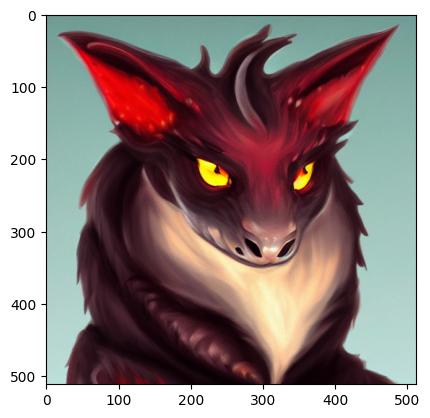

In [ ]:

img = model.generate(
    "Furry dragon fursona icon with black body fur, red neck fur and red eyes, "
    "high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting",
    num_steps=50,
    unconditional_guidance_scale=7.5,
    temperature=1,
    batch_size=3,
)

# for image to image :
# img = generator.generate(
#     "A Halloween bedroom",
#     num_steps=50,
#     unconditional_guidance_scale=7.5,
#     temperature=1,
#     batch_size=1,
#     input_image="/path/to/img.png"
# )


Image.fromarray(img[0]).save("output2.png")
plt.imshow(img[0])

In [ ]:
i=1
print(i)

3


In [ ]:
i=0
img = model.generate(
    "furry dragon fursona, black body fur, red neck fur, red eyes, smug smile, looking at viewer"
    "high quality, highly detailed, epic, beautiful"
    "character concepts,",
    num_steps=50,
    unconditional_guidance_scale=7.5,
    temperature=1,
    batch_size=1,
)
for j in range(len(img)):
  i+=1
  Image.fromarray(img[j]).save(f"output{i}.png")

  0   1: 100%|██████████| 50/50 [1:50:04<00:00, 132.09s/it]


In [ ]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(img)

### Fine-tuning

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

AttributeError: ignored

In [ ]:
model.summary()

AttributeError: ignored

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
)

AttributeError: ignored